In [1]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import graphviz
from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## Loading the data and labels

In [39]:
data_path = r".\datasets"
classes = [1,1,1,2,2,3,3,3,2,2,0,0,0,1]
split_size = 0.8

for i in range(1,15):
    path = data_path + f"\experiment_{i:03d}"
    dp_mat_loc = path + "\\range_dopler_map.npy"
    with open(dp_mat_loc,'rb') as f:
        data = np.load(f)
        
    
    if i==1:  
        x = np.abs(data[...])
        y = classes[i-1]*np.ones(np.shape(data)[0])
        
    else:
        x = np.abs(np.concatenate((x,data[...]),axis=0))
        y = np.concatenate((y,classes[i-1]*np.ones(np.shape(data)[0])))

(12350, 3, 64, 64)


## Peprocessing the data by removing the DC component and normalization

In [4]:
# Preprocessing data
width=1
x_dc = np.mean(x_train[:,:,32-width:32+width+1,:],axis=0)
x_train_preprocessed = x_train.copy()
x_train_preprocessed[:,:,32-width:32+width+1,:] = 0
x_train = x_train_preprocessed

x_train[:,0,...] /= np.max(x_train[:,0,...])
x_train[:,1,...] /= np.max(x_train[:,1,...])
x_train[:,2,...] /= np.max(x_train[:,2,...])

## Setting seed for random, numpy and tensorflow libraries

In [9]:
seed_constant = 22
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### Visualisation of one class

0
1
2
3


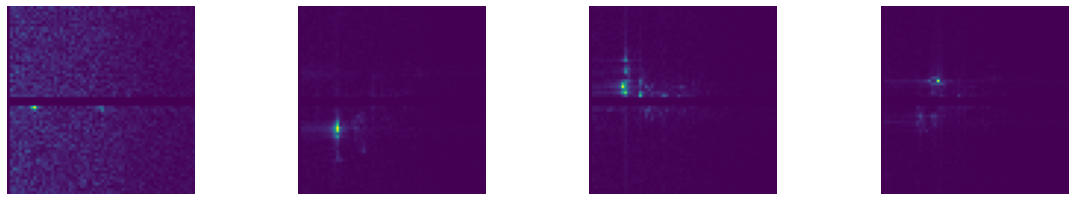

In [10]:
plt.figure(figsize = (20, 20))

all_classes_names = [0, 1, 2, 3]

for counter, random_index in enumerate(all_classes_names, 1):

    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = y_train[y_train==selected_class_Name]
    video_files = x_train[y_train==selected_class_Name]
    selected_video_file_name = random.randint(1,len(video_files_names_list)-1)
    
    rgb_frame = video_files[selected_video_file_name]
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame[0,:,:]);plt.axis('off')

### Setting some of the parameters

In [11]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 10

DATASET_DIR = "dataset"

CLASSES_LIST = ["0", "1", "2", "3"]

### Creating sequence dataset

In [15]:
X = []
Y = []
for i in range(0,y.shape[0]-SEQUENCE_LENGTH,int(SEQUENCE_LENGTH/2)):
    X.append(x[i:i+SEQUENCE_LENGTH,...]/np.max(x[i:i+SEQUENCE_LENGTH,...]))
    Y.append(y[i])
features = np.array(X)
labels = np.array(Y)

print(np.shape(X))


(2468, 10, 3, 64, 64)


## Sequence visualisation

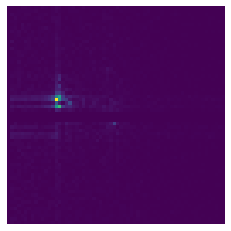

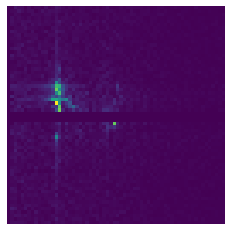

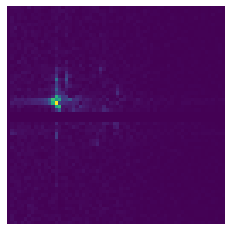

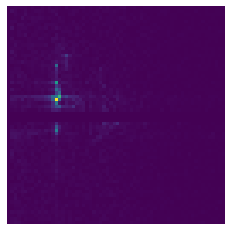

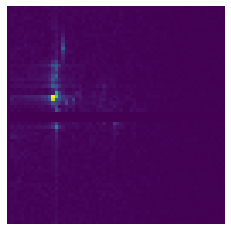

In [16]:
fig=plt.figure()
plt.imshow(features[2467,0,1,...])
plt.axis('off')
plt.show()
fig=plt.figure()
plt.imshow(features[2467,1,1,...])
plt.axis('off')
plt.show()
fig=plt.figure()
plt.imshow(features[2467,2,1,...])
plt.axis('off')
plt.show()
fig=plt.figure()
plt.imshow(features[2467,3,1,...])
plt.axis('off')
plt.show()
fig=plt.figure()
plt.imshow(features[2467,4,1,...])
plt.axis('off')
plt.show()

In [17]:
one_hot_encoded_labels = to_categorical(labels)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


### Train-test split

In [18]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.10, shuffle = True,
                                                                            random_state = 0)

In [21]:
def create_LRCN_model():


    # We will use a Sequential model for model construction.
    model = Sequential()
    
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [22]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 64, 64, 16)    448       
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 64, 64, 16)    64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 16, 16, 32)    4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 16, 16, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 4, 4, 32)      0

In [25]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

features_train2 = np.transpose(features_train,(0,1,3,4,2))

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train2, y = labels_train, epochs = 20, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.15, callbacks = [early_stopping_callback])

In [36]:
# Evaluate the trained model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

features_test2 = np.transpose(features_test,(0,1,3,4,2))
model_evaluation_history = LRCN_model.evaluate(features_test2, labels_test)

8/8 [==============================] - 2s 97ms/step - loss: 0.1749 - accuracy: 0.9514


In [31]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'7LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [32]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

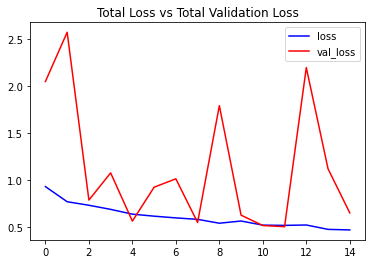

In [34]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

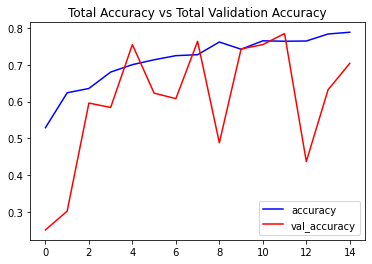

In [35]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [22]:

LRCN_model = create_LRCN_model()
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

weights_lrcn = "6LRCN_model__double_data_seq5_3deadrows.h5"
#weights_lrcn = '7LRCN_model___Date_Time_2022_05_26__17_00_07___Loss_0.6486591696739197___Accuracy_0.7248986959457397.h5'
LRCN_model.load_weights(weights_lrcn)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 64, 64, 16)    448       
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 64, 64, 16)    64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 16, 16, 32)    4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 16, 16, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 4, 4, 32)      0